In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import datetime

In [2]:
from scipy import signal

# Prep

In [3]:
import pathlib
outdir = pathlib.Path('output')

outdir.mkdir(exist_ok=True)

# Download and process data

In [4]:
shifts = pd.read_csv('static/shifts.csv', index_col='province')

In [5]:
cases_url = "data/covid19za_provincial_cumulative_timeline_confirmed.csv"
deaths_url = "data/covid19za_provincial_cumulative_timeline_deaths.csv"

In [6]:
provinces = ['EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC', 'SA']

In [7]:
province = 'GP'
outformat = 'pdf'
show_deathmodel = False
show_deathprediction = True

In [8]:
def read_source(url):
    df = pd.read_csv(url, parse_dates=['date'], index_col='date', dayfirst=True).rename(columns={'total': 'SA'})
    del df['YYYYMMDD']
    df = df[provinces] #.melt(var_name='province')
    return df

In [9]:
cases = read_source(cases_url)
deaths = read_source(deaths_url)

In [10]:
newcases = cases[province].diff()
newdeaths = deaths[province].diff()

In [11]:
today = max(cases.index).date()

In [12]:
levels = pd.read_csv('static/levels.csv', parse_dates=['date'])
levels = levels.append({'date': today, 'level': levels.iloc[-1]['level']}, ignore_index=True)

## Predict the future from the past

In [13]:
startdate = shifts.loc[province, 'startdate']
shift = int(shifts.loc[province, 'shift'])

In [14]:
shifted = newcases[startdate:].shift(shift*7, '1D')
shifted_rolling = shifted.rolling('7D').mean()

In [15]:
mappednewcases = shifted[today:]

In [16]:
combined = pd.DataFrame({'cases': pd.concat([newcases, mappednewcases]), 'deaths': newdeaths})['2020-06':]

# Simple delayed death model

In [17]:
ksize = 101  # kernel size

In [18]:
days = np.arange(1, ksize)

Initial parameters

In [19]:
case_fatality_days = [0, 100, 200, 300, 400]  # times of changes in case fatality
case_fatality_values = [0.02, 0.03, 0.03, 0.02, 0.02]
case_fatality_points = len(case_fatality_days)

In [20]:
def case_fatality_over_time(case_fatality_days, case_fatality_values, times):
    # interp = sci.interp1d(
    #     case_fatality_days, 
    #     case_fatality_values, 
    #     kind='cubic', 
    #     bounds_error=False, 
    #     fill_value=case_fatality_values[-1])
    # case_fatality = interp(times)
    case_fatality = np.interp(times, case_fatality_days, case_fatality_values)
    return case_fatality

In [21]:
shape = 4
scale = 5

In [22]:
pars =  [shape, scale] + case_fatality_days + case_fatality_values

In [23]:
def kernel_func(shape, scale):
    return stats.distributions.gamma.pdf(days, shape, scale=scale)

In [24]:
def case_fatality_from_pars(pars, target):
    shape, scale, *case_fatality_pars = pars

    halfway = int(len(case_fatality_pars)//2)
    case_fatality_days = case_fatality_pars[:halfway]
    case_fatality_values = case_fatality_pars[halfway:]

    times = np.arange(len(target))
    case_fatality = case_fatality_over_time(
        case_fatality_days,
        case_fatality_values,
        times
    )

    return case_fatality

In [25]:
def model(pars):
    shape, scale, *_ = pars
       
    kernel = np.zeros(ksize*2-1)

    kernel[ksize:] = kernel_func(shape, scale)
    
    case_fatality = case_fatality_from_pars(pars, combined)
    prediction = signal.convolve(combined.cases*case_fatality, kernel, mode='same')
    
    return prediction

In [26]:
def plotmodel(shape, scale, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.title
    kernel = kernel_func(shape, scale)
    ax.plot(kernel)
    ax.set(
        xlabel='Days',
        ylabel='Chance of dying',
        title='Death model',
    )
#     ax.axvline(scale)

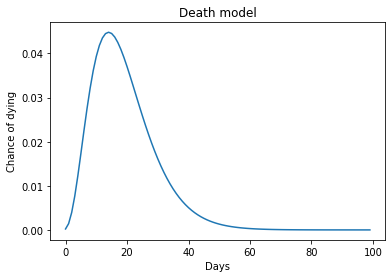

In [27]:
plotmodel(shape, scale)

In [28]:
prediction = model(pars)

In [29]:
def error(pars):
    prediction = model(pars)
    combined['prediction'] = prediction
    return ((deaths[province] - combined['prediction'].cumsum())**2).sum()

In [30]:
from scipy.optimize import minimize

In [31]:
shapebounds = ((1, 10), (1, 10), )

In [32]:
daybounds = ((0, len(combined)),)*case_fatality_points

In [33]:
ratebounds = ((0.001, 0.1),)*case_fatality_points

In [34]:
opt = minimize(error, pars, bounds=shapebounds+daybounds+ratebounds)

In [35]:
opt.x

array([3.77637573e+00, 4.81003616e+00, 8.09985067e+01, 7.97387678e+01,
       2.07288122e+02, 3.11089478e+02, 3.99884194e+02, 1.90885417e-02,
       4.97989456e-02, 2.70424026e-02, 4.03681260e-02, 1.38497914e-02])

In [36]:
prediction = model(opt.x)

In [37]:
combined['prediction'] = prediction

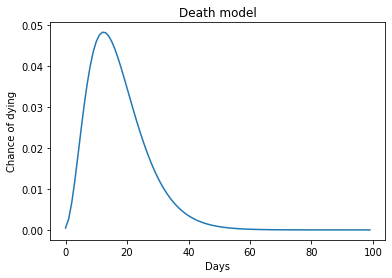

In [38]:
plotmodel(*opt.x[:2])

In [39]:
combined['case_fatality'] = case_fatality_from_pars(opt.x, combined)

In [40]:
len(combined)

633

<AxesSubplot:xlabel='date'>

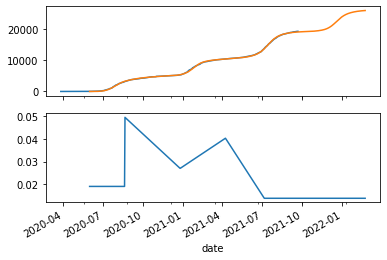

In [41]:
fig, (axdeaths, axrate) = plt.subplots(2, 1, sharex=True)
deaths[province].plot(ax=axdeaths)
combined['prediction'].cumsum().plot(ax=axdeaths)
combined['case_fatality'].plot(ax=axrate)

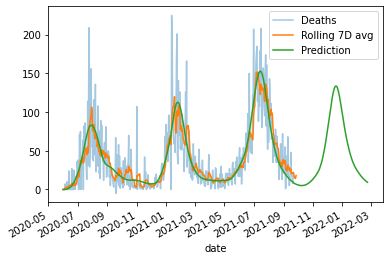

In [42]:
combined['deaths'].plot(alpha=0.4, label='Deaths')
combined['deaths'].rolling('7D').mean().plot(label='Rolling 7D avg')
combined['prediction'].plot(label='Prediction')
plt.legend()

In [43]:
peak_rate = newcases.max()
previous_peak_rate = newcases[:pd.to_datetime(startdate)+datetime.timedelta(days=shift)].max()
cutoff = 0.3

In [44]:
predicted_third_wave = (shifted_rolling[:'2021-06-15'] - peak_rate*cutoff).abs().idxmin()
predicted_third_wave

Timestamp('2021-06-12 00:00:00')

In [45]:
deathroll = '7D'

In [46]:
from more_itertools import pairwise

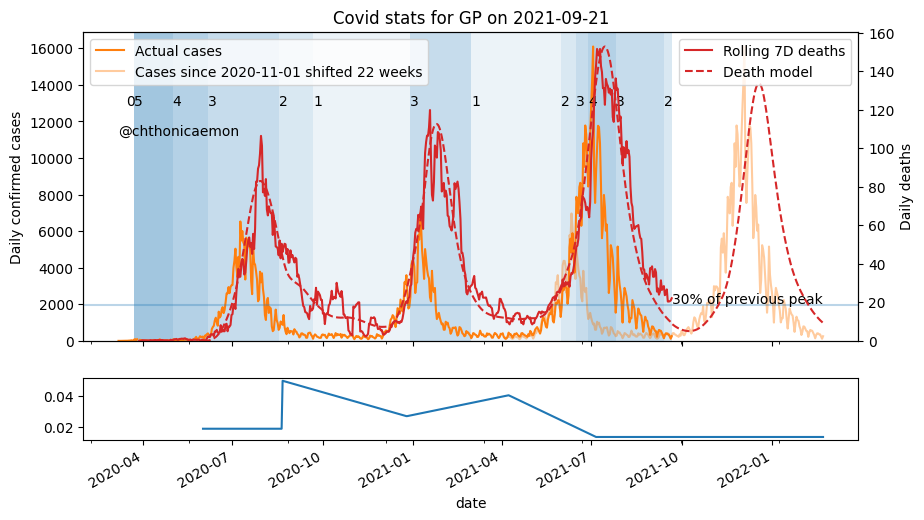

In [48]:
fig, (ax_cases, ax_rate) = plt.subplots(
    2, 1, 
    figsize=(10, 6),
    dpi=100, 
    gridspec_kw={'height_ratios': [5, 1]},
    sharex=True
)
ax_deaths = ax_cases.twinx()
# ax_deaths.spines['right'].set_edgecolor('C3')

for left, right in pairwise(levels.itertuples()):
    ax_cases.axvspan(left.date, right.date, alpha=left.level/12)
    ax_cases.annotate(left.level, (left.date, peak_rate*0.8))

newcases.plot(ax=ax_cases, color='C1', label='Actual cases')
shifted.plot(ax=ax_cases, color='C1', alpha=0.4, label=f'Cases since {startdate} shifted {shift} weeks')

newdeaths.rolling(deathroll).mean().plot(ax=ax_deaths, label=f'Rolling {deathroll} deaths', color='C3')
if show_deathprediction:
    combined['prediction'].plot(ax=ax_deaths, label="Death model", color='C3', style='--')
# newcases.rolling('7D').mean().plot()
# ax_cases.axvline(predicted_third_wave, alpha=0.3)
ax_cases.set(
    xlabel='Date',
    ylabel=f'Daily confirmed cases',
    title=f"Covid stats for {province} on {today}",
)
ax_cases.set_ylim(bottom=0)
ax_deaths.set_ylim(bottom=0)
ax_deaths.set(
    ylabel='Daily deaths'
)
ax_cases.legend(loc="upper left")
ax_deaths.legend(loc="upper right")

ax_cases.text(combined.index[-1], previous_peak_rate*cutoff*1.05, f'{cutoff:.0%} of previous peak', horizontalalignment='right')
ax_cases.axhline(previous_peak_rate*cutoff, alpha=0.3)

ax_cases.text(newcases.index[1], peak_rate*0.7, '@chthonicaemon')

# ax_cases.text(predicted_third_wave, 100, predicted_third_wave.date())
if show_deathmodel:
    ax_model = ax_cases.inset_axes([0.78, 0.65, 0.2, 0.2])
    plotmodel(*opt.x, ax_model)

combined['case_fatality'].plot(ax=ax_rate)

plt.savefig(f'output/covid_{province}.{outformat}')